<a href="https://colab.research.google.com/github/theplow-kwak/madi/blob/main/madi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
 
nb_path = '/content/notebooks'
 
if 'drive' not in os.listdir():
    drive.mount('/content/drive')
    os.symlink('/content/drive/My Drive/Colab Notebooks/modules', nb_path)
 
if nb_path not in sys.path:
    sys.path.insert(0,nb_path)

ModuleNotFoundError: No module named 'google'

pip install finance-datareader
pip install bs4
pip install mplfinance

In [1]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
 
stock_type = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt'
}
 
class StockCodes: 
    def __init__(self, mt=None):
        self.get_method = mt
        if self.get_method is None:
            self.stock_codes()
        else:
            self.codes2 = fdr.StockListing('KRX')[['Market','Name','Symbol']]
            self.codes2 = self.codes2.rename(columns={'Market':'market','Name': 'name', 'Symbol': 'code'})

    def krx_stock_codes(self, market_type='kospi'):
        download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
        download_link = download_link + '?method=download'
        download_link = download_link + '&marketType=' + stock_type[market_type]
        df = pd.read_html(download_link, header=0)[0]
        df['market'] = 'KS' if market_type == 'kospi' else 'KQ'
        return df

    def get_code(self, name, target=None):
        code = self.codes.query("name=='{}'".format(name))
        if len(code.index) == 0:
            return '000000'
        if target:
            code = '{:06d}.{}'.format(code.code.item(), code.market.item())
        else:
            if self.get_method is None:
                code = '{:06d}'.format(code.code.item())
            else:
                code = '{}'.format(code.code.item())
        return code

    def find(self, name):
        str_expr = "name.str.contains('{}')".format(name)
        print(str_expr)
        code = self.codes.query(str_expr, engine='python')
        return code

    def stock_codes(self):
        kospi = self.krx_stock_codes('kospi')
        kosdaq = self.krx_stock_codes('kosdaq')

        self.codes = pd.concat([kospi, kosdaq], ignore_index=True)
        self.codes = self.codes[['market','회사명', '종목코드']]
        self.codes = self.codes.rename(columns={'회사명': 'name', '종목코드': 'code'})

    #    url = 'http://media.kisline.com/highlight/mainHighlight.nice?nav=1&paper_stock={:06d}'.format(code.code.item())
    def getFinancefromNaver(self, name):
        code = self.codes.query("name=='{}'".format(name))
        url = 'http://finance.naver.com/item/main.nhn?code={:06d}'.format(code.code.item())
        print(url)
        tables = pd.read_html(url, encoding='euc-kr')[3]
        tables.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
        tables.index.rename('주요재무정보', inplace=True)
        tables.columns = tables.columns.droplevel(2)
        tables.columns = tables.columns.droplevel(0)
        return tables
 
 
def readData(name, start=None, end=None):
    data = fdr.DataReader(stock_codes.get_code(name), start, end)
    #data = pdr.get_data_yahoo(get_code(name))

    print(data[(data[['High','Low','Close']] == 0).any(axis=1)])
    data = data[~(data[['High','Low','Close']] == 0).any(axis=1)]
    
    timep = 240
    data['high'] = data['High'].rolling(window=timep).max() 
    data['low'] = data['Low'].rolling(window=timep).min() 
    data['enval'] = data['Close'].rolling(window=20).mean() 
    data['mav120'] = data['Close'].rolling(window=120).mean() 
    data['mav240'] = data['Close'].rolling(window=240).mean() 
    data['e_high'] = data['enval'] * 1.2 
    data['e_low'] = data['enval'] * 0.8
    data['madi50'] = data['low'] + (data['high'] - data['low']) * 0.5
    data['madi60'] = data['low'] + (data['high'] - data['low']) * 0.4
    data['madi70'] = data['low'] + (data['high'] - data['low']) * 0.3
    data['madi80'] = data['low'] + (data['high'] - data['low']) * 0.2
    data['madi90'] = data['low'] + (data['high'] - data['low']) * 0.1
    data['v_high'] = data['Volume'].rolling(window=timep).max() 

    #if data['high'][-1]
    print(data['high'][-1], data['low'][-1], (data['high'][-1]/ data['low'][-1]) * 100)
    print(data['Close'][-1], data['madi50'][-1])
    return data
 
 
%matplotlib inline 
import pandas as pd
import mplfinance as mpf
 
def drawchart(name, range=200):

    tdata = readData(name, '2017')
    data = tdata[-range:]

    #fig = mpf.figure(style='yahoo',tight_layout=True, figsize=(12,5))
    #ax1 = fig.add_subplot(2,1,1)
    #ax2 = fig.add_subplot(2,1,2)  

    ap0 = [
        mpf.make_addplot(data[['madi60', 'madi70', 'madi80', 'madi90']], color='blue', width=0.5),
        mpf.make_addplot(data[['madi50']],color='g', width=1.5),
        mpf.make_addplot(data[['mav120']],color='teal', width=1),
        mpf.make_addplot(data[['mav240']],color='orange', width=1),
        mpf.make_addplot(data[['high', 'low']],color='c', width=0.5),
        mpf.make_addplot(data[['enval']],color='red', width=1),
        mpf.make_addplot(data[['e_high', 'e_low']],color='black', width=0.5),
        mpf.make_addplot(data[['v_high']],color='black', panel=1, ylabel='Volume', width=0.5),
        ]

    mc = mpf.make_marketcolors(
                              up='red',down='blue',
                              inherit=True
                            )
    s  = mpf.make_mpf_style(base_mpf_style="yahoo", edgecolor='black', marketcolors=mc)
    kwargs = dict(type='candle',
            #title=stock_codes.get_code(name),
            ylabel='Price',
            figratio=(4,2),
            panel_ratios=(10,2),
            addplot=ap0)

    mpf.plot(data, **kwargs, volume=True, style = s)
 
stock_codes = StockCodes()

            Open  High  Low  Close  Volume  Change
Date                                              
2021-07-23     0     0    0   6590       0     0.0
2021-07-26     0     0    0   6590       0     0.0
2021-07-27     0     0    0   6590       0     0.0
2021-07-28     0     0    0   6590       0     0.0
2021-07-29     0     0    0   6590       0     0.0
2021-07-30     0     0    0   6590       0     0.0
2021-08-02     0     0    0   6590       0     0.0
2021-08-03     0     0    0   6590       0     0.0
2021-08-04     0     0    0   6590       0     0.0
2021-08-05     0     0    0   6590       0     0.0
2021-08-06     0     0    0   6590       0     0.0
2021-08-09     0     0    0   6590       0     0.0
8061.0 5048.0 159.68700475435816
6420 6554.5


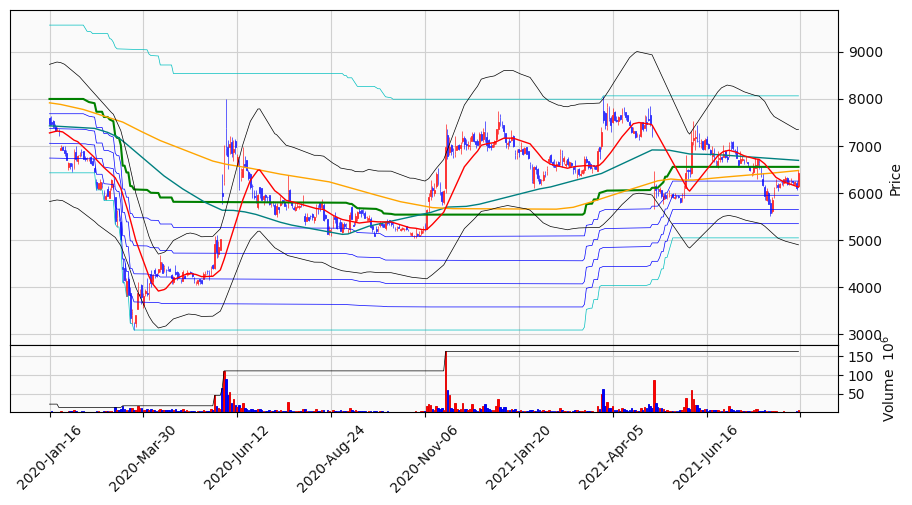

http://finance.naver.com/item/main.nhn?code=010140


,2018.12,2019.12,2020.12,2021.12(E),2020.06,2020.09,2020.12,2021.03,2021.06,2021.09(E)
주요재무정보,,,,,,,,,,
매출액,52651,73497,68603,68812,16915.00,16768.00,16654.00,15746.00,17155.00,17363.00
영업이익,-4093,-6166,-10541,-9187,-7077.00,-134.00,-2851.00,-5068.00,-4379.00,-616.00
당기순이익,-3882,-13154,-14927,-9825,-7042.00,-74.00,-5541.00,-5359.00,-4474.00,-800.00
영업이익률,-7.77,-8.39,-15.37,-13.35,-41.84,-0.80,-17.12,-32.18,-25.53,-3.55
순이익률,-7.37,-17.90,-21.76,-14.28,-41.63,-0.44,-33.27,-34.03,-26.08,-4.61
ROE(지배주주),-6.19,-21.88,-33.05,-28.14,-33.57,-24.35,-33.05,-41.59,-41.30,NaN
부채비율,111.72,159.10,247.54,NaN,211.03,208.65,247.54,261.86,322.23,NaN
당좌비율,43.36,28.91,35.93,NaN,31.89,36.52,35.93,36.01,33.87,NaN
유보율,145.91,104.71,57.72,NaN,75.17,75.20,57.72,40.77,26.62,NaN


In [5]:
s_name = '삼성중공업'
drawchart(s_name,400)
stock_codes.getFinancefromNaver(s_name)

In [33]:
stock_codes.codes

,market,name,code
0,KS,DRB동일,4840
1,KS,DSR,155660
2,KS,GS글로벌,1250
3,KS,HDC현대산업개발,294870
4,KS,KEC,92220
...,...,...,...
2319,KQ,한라IMS,92460
2320,KQ,한스바이오메드,42520
2321,KQ,현대사료,16790
2322,KQ,홈센타홀딩스,60560


In [44]:
stock_codes.codes2.market.value_counts()

KOSPI     5299
KOSDAQ    1531
KONEX      134
Name: market, dtype: int64